# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name: Aditya Raj Verma
 
ID:   A53219148

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

#environment
import gym

#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

logging_interval = 100
animate_interval = logging_interval * 5
logdir='./DDPG/'

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [2]:
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
# env_name = 'InvertedPendulum-v2'
env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v2' 

# wrap gym to save videos
env = gym.make(env_name)
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

def to_numpy(var):
    return var.cpu().data.numpy() if use_cuda else var.data.numpy()

def to_tensor(x, volatile=False, requires_grad=True, dtype=Tensor):
    x = torch.from_numpy(x).float()
    x = Variable(x, requires_grad=requires_grad).type(dtype)
    return x

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

Ans: 


### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [3]:
class NormalizeAction(gym.ActionWrapper):
    def _reverse_action(self, action):
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        self.low = self.action_space.low
        self.high = self.action_space.high
        self.mid = self.low + (self.high - self.low)/2
        self.range = (self.high - self.low)/2.
        return (action-self.mid)/self.range 

    def _action(self, action):
        #reverse of that above
        self.low = self.action_space.low
        self.high = self.action_space.high
        self.mid = self.low + (self.high - self.low)/2
        self.range = (self.high - self.low)/2.
        return action * self.range + self.mid

# DDPG

In [4]:
env = gym.make(env_name)
env = NormalizeAction(env)
dim_state = env.observation_space.shape[0]
dim_action = env.action_space.shape[0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [5]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [6]:
from collections import defaultdict

class Replay:
    def __init__(self, env, batch_size = 128):
        
        self.capacity = 60000 
        #  For each experience - 5 information will be saved 
        self.memory = []   #[state, action, reward, next_state, done]
        self.curr_index = 0
        self.size = 0
        self.batch_size = batch_size
        
        # Setup
        self.env = env
        
        # Call function to add initial 1000 experiences so that training can start
        self.initializeInitialExperience()
        
    def initializeInitialExperience(self):
        state = self.env.reset()
        for i in range(1000):
            # Need to Add 1000 experience
            action = np.random.uniform(low = -1.0, high = 1.0, size = self.env.action_space.shape[0] )
            next_state, reward, done , _ = self.env.step(action)
            
            self.add_experience(state, action, reward, next_state, done)
            self.curr_index += 1
            state = next_state
            if done:
                state = env.reset()
        
    def add_experience(self, state, action, reward, next_state, done):
        if self.curr_index >= self.capacity:
            self.curr_index = 0
        curr_experience = defaultdict()
        curr_experience['state'] = state
        curr_experience['action'] = action
        curr_experience['reward'] = reward
        curr_experience['next_state'] = next_state
        curr_experience['done'] = done
        
        if self.size < self.capacity:
            self.memory.append(curr_experience)
        else:
            self.memory[self.curr_index] = curr_experience
        self.curr_index += 1
        self.size = min(self.size + 1, self.capacity )
        
    def sample(self, batch_size = None ):
        batch_size = batch_size if batch_size else self.batch_size

        # Prepare batch-data holder 
        batch_state = np.zeros(shape=(batch_size, dim_state))
        batch_action = np.zeros(shape=(batch_size, dim_action))
        batch_reward = np.zeros(shape=(batch_size,1))
        batch_next_state = np.zeros(shape=(batch_size, dim_state))
        batch_done = np.zeros(shape=(batch_size,1))

        
        # Sample mini-batch
        sampled_experiences = random.sample(self.memory, batch_size)
        
        # Copy sampled minibatch to numpy array
        for i,curr_experience in enumerate(sampled_experiences):
            batch_state[i] = curr_experience['state']
            batch_action[i] = curr_experience['action']
            batch_reward[i] = curr_experience['reward'].reshape((-1,1))
            batch_next_state[i] = curr_experience['next_state']
            batch_done[i] = curr_experience['done']
            
        return batch_state, batch_action, batch_reward, batch_next_state, batch_done

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [7]:
class OrnsteinUhlenbeckProcess(object):
    def __init__(self, dimension, num_steps, theta=0.25, mu=0.0, sigma=0.05, dt=0.01):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x = np.zeros((dimension,))
        self.iter = 0
        self.num_steps = num_steps
        self.dimension = dimension
        self.min_epsilon = 0.01 # minimum exploration probability
        self.epsilon = 1.0
        self.decay_rate = 5.0/num_steps # exponential decay rate for exploration prob
    
    def sample(self):
        self.x = self.x + self.theta*(self.mu-self.x)*self.dt + \
                                       self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.dimension)
        return self.epsilon*self.x
    
    def reset(self):
        self.x = 0*self.x
        self.iter += 1
        self.epsilon = self.min_epsilon + (1.0 - self.min_epsilon)*np.exp(-self.decay_rate*self.iter)

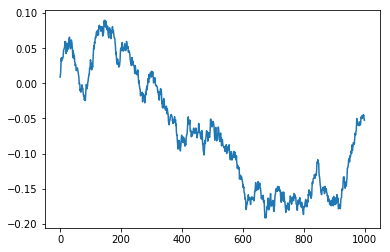

In [8]:
noise =  OrnsteinUhlenbeckProcess(dimension=1,num_steps=1000)
y = np.zeros((1000))
for i in range(1000):
    y[i] = noise.sample()
plt.plot(range(1000),y)
plt.show()

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [16]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(actor, self).__init__()
        
        # Input/Output shapes
        self.dim_state = input_size
        self.dim_action = output_size
        
        self.fc1 = nn.Linear(self.dim_state , 400 )
        self.bn1 = nn.BatchNorm1d(400)
        self.fc2 = nn.Linear(400, 400 )
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, self.dim_action)
        
        # Xavier initialization of layers
        self.apply(init_weights)
        
    def forward(self, state):
        # Pass state through FC layer
        out = self.fc1(state)
        out = self.bn1(out)
        out = F.relu(out)
        # Concatenate fc_state and action 
        out = self.fc2(out)
        out = self.bn2(out)
        out = F.relu(out)
        predicted_action = F.tanh( self.fc3(out))
        return predicted_action

# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self, state_size, action_size, output_size = 1):
        super(critic, self).__init__()
        
        # Input/Output shapes
        self.dim_state = state_size
        self.dim_action = action_size
        
        self.fc1 = nn.Linear(self.dim_state , 300 )
        self.fc2 = nn.Linear(300 + self.dim_action, 300 )
        self.fc3 = nn.Linear(300, output_size)
        
        # Xavier initialization of layers
        self.apply(init_weights)
        
    def forward(self, state, action):
        # Pass state through FC layer
        out = F.relu( self.fc1(state) )
        # Concatenate fc_state and action 
        out = F.relu(  self.fc2(torch.cat([out, action], 1))      )
        q_value = self.fc3(out)
        return q_value

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [11]:
from pdb import set_trace as bp

In [3]:
OBS_DIM = env.observation_space.shape[0]
ACT_DIM = env.action_space.shape[0]

In [63]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):

        alpha_decay = 0.93
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE

        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor.cuda()
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.cuda()
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic.cuda()
        self.critic_target.cuda()
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)

        # learning rate scheduler
        self.scheduler_actor = optim.lr_scheduler.StepLR(self.optimizer_actor, step_size=5000, gamma=alpha_decay)
        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer_critic, step_size=5000, gamma=alpha_decay)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay(env)
        


    
    def train(self):
        # sample from Replay
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = self.replayBuffer.sample(self.batch_size)

        # update critic (create target for Q function)
        target_q = self.critic_target( to_tensor(batch_next_state, volatile = True),\
                                       self.actor_target(to_tensor(batch_next_state,volatile = True)) )
        true_q = to_numpy( to_tensor(batch_reward) + self.gamma * target_q * to_tensor(1-batch_done) )

        predicted_q = self.critic(to_tensor(batch_state), to_tensor(batch_action))
        critic_loss = self.critic_loss( predicted_q,  to_tensor(true_q, requires_grad = False) )

       
        # critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        self.critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        self.scheduler_critic.step()

#         # update actor (formulate the loss wrt which actor is updated)
        policy_loss = -self.critic(to_tensor(batch_state), self.actor(to_tensor(batch_state)))
        policy_loss = policy_loss.mean()
#         # actor optimizer and backprop step (loss_actor.backward())
        self.actor.zero_grad()
        policy_loss.backward()
        self.optimizer_actor.step()
        self.scheduler_actor.step()

#         # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [64]:
ddpg = DDPG(obs_dim = dim_state, act_dim = dim_action)
print(ddpg.actor)
print(ddpg.critic)

actor(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
critic(
  (fc1): Linear(in_features=3, out_features=300, bias=True)
  (fc2): Linear(in_features=301, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [65]:
# env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
term_condition = -150 # Pendulum

for itr in range(NUM_EPISODES):
    state = env.reset() # get initial state
    ddpg.noise.reset()
    step = 0
    total_reward = 0
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE

    while True:
        ddpg.noise.reset()

        if animate_this_episode:
                env.render()
                time.sleep(0.05)

        # use actor to get action, add ddpg.noise.step() to action
        ddpg.actor.eval()
        state = state.reshape(1,-1)
        noise = ddpg.noise.sample()
        action = to_numpy(ddpg.actor(to_tensor(state))).reshape(-1,)+noise
        
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
                
        # step action, get next state, reward, done (keep track of total_reward)
        # populate ddpg.replayBuffer
        next_state, reward, done, _ = env.step(action)
        ddpg.replayBuffer.add_experience(state.ravel(), action, reward, next_state, done)
        total_reward += reward
        
        ddpg.train()
        step_counter += 1
        
        if done:
            break
        state = next_state
        
    
    print(step_counter, total_reward)

    if avg_val > term_condition and itr > 10:
        break

    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))


200 -1341.2721850292692
Average value: -67.06360925146346 for episode: 0
400 -1477.1529868276878
Average value: -137.56807813027467 for episode: 1
600 -1583.952216391029
Average value: -209.88728504331237 for episode: 2
800 -1437.0582631055781
Average value: -271.24583394642565 for episode: 3
1000 -1409.7933954183197
Average value: -328.17321202002034 for episode: 4
1200 -1507.3720746285403
Average value: -387.1331551504463 for episode: 5
1400 -1510.698249565345
Average value: -443.31140987119124 for episode: 6
1600 -1521.537884449595
Average value: -497.2227336001114 for episode: 7
1800 -1412.6491331125048
Average value: -542.9940535757311 for episode: 8
2000 -1180.7075106615273
Average value: -574.8797264300209 for episode: 9
2200 -1479.6183793799828
Average value: -620.116659077519 for episode: 10
2400 -1484.4203784455938
Average value: -663.3318450459227 for episode: 11
2600 -1427.6350626606622
Average value: -701.5470059266597 for episode: 12
2800 -1453.0812756357307
Average value

22000 -145.37927429537072
Average value: -274.7772327290754 for episode: 109
22200 -142.5280429987009
Average value: -268.16477324255663 for episode: 110
22400 -248.98999306630498
Average value: -267.20603423374405 for episode: 111
22600 -350.26429178896257
Average value: -271.35894711150496 for episode: 112
22800 -139.82164767402728
Average value: -264.7820821396311 for episode: 113
23000 -20.11867468122012
Average value: -252.54891176671055 for episode: 114
23200 -365.58960359612246
Average value: -258.2009463581811 for episode: 115
23400 -140.16090632626452
Average value: -252.29894435658528 for episode: 116
23600 -142.11691287026144
Average value: -246.7898427822691 for episode: 117
23800 -15.86541186106106
Average value: -235.24362123620867 for episode: 118
24000 -140.71763608398632
Average value: -230.51732197859752 for episode: 119
24200 -138.08582073350925
Average value: -225.89574691634309 for episode: 120
24400 -137.62459039950366
Average value: -221.48218909050112 for episod

KeyboardInterrupt: 

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

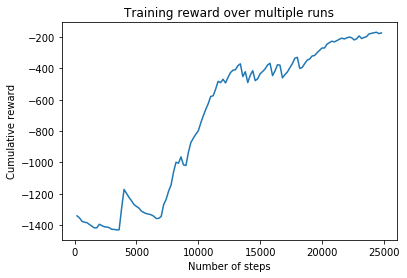

In [66]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.




In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    
    def __init__(self, discrete, input_size, output_size, learning_rate = 1e-3):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Continuous vs Discrete
        if discrete:
            self.fc3 = nn.Linear(128, output_size)
        else:
            self.fc3 = nn.Linear(128, 2*output_size)
        self.apply(init_weights)
        
        # Initialize optimizer
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.parameters(), lr = self.learning_rate)
    
    def forward(self, inp):
        # Layer 1
        x = self.fc1(inp)
        x = F.relu(x)
        # Layer 2
        x = self.fc2(x)
        x = F.relu(x)
        # Output layer - Continuous vs Discrete
        if discrete:
            out = F.softmax(self.fc3(x), dim = -1)    ## Probabilities of categorical actions
        else:
            out = self.fc3(x)                 ## Mean and variance of actions [ mu1, mu2,......, var1, var2,....]
        return out

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [5]:
def sample_action(logit, discrete):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 

    n_actions = logit.shape[0]//2
    # Discrete action space: categorical distribution
    if discrete:
        dist = torch.distributions.Categorical(probs = logit)
    # Continuous action space: Normal distribution
    else:
        means     = x[:n_actions]
        # predicted variance are in range 1. Rescale to the action-space
        variances = F.sigmoid(x[n_actions:]) * to_tensor(env.action_space.high - env.action_space.low)
        dist      = torch.distributions.Normal(means, variances)
    
    sampled_action = dist.sample()
    log_prob       = dist.log_prob(sampled_action) 
    return sampled_action.cpu().data.numpy()[0], log_prob

Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [85]:
def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object
    
    num_paths = len(paths)
    losses = to_tensor(np.zeros(num_paths))
    
    for path_idx,path in enumerate(paths):
        
         # rew_cums should record return at each time step for each path 
        len_path = path['length']
        rew_cums = np.zeros(path['log_odds'].shape)
        # For the current path, move backward to calculate cumulative rewards
        rew_cums[-1] = path['reward'][-1]
        for i in range(len_path-2,-1,-1):
            rew_cums[i] = rew_cums[i+1] + path['reward'][i]
            # log_odds should record log_odds obtained at each timestep of path
            # calculated as "reward to go"
        
        rew_cums = (rew_cums - rew_cums.mean()) / (rew_cums.std() + 1e-5) # create baseline
        # Loss = Rewards, weighted by grad log probability of action
    # make log_odds, rew_cums each a vector
    losses[path_idx] = -( to_tensor(rew_cums, requires_grad = False) * path['log_odds']).sum() # Negative for gradient ascent
    
    # calculate policy loss and average over paths
    loss = losses.mean()    
    # take optimizer step
    net.optimizer.zero_grad()
    loss.backward()
    net.optimizer.step()

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [87]:
# Select Environment
min_timesteps_per_batch = 2000  # sets the batch size for updating network

#discrete environment:
# env_name='CartPole-v0'

#continous environments:
env_name='InvertedPendulum-v2'
#env_name = 'HalfCheetah-v2'

# env_name='InvertedPendulum-v2'

# Make the gym environment
env = gym.make(env_name)
visualize = False
animate=visualize

learning_rate = 1e-3

max_path_length=None


# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/'


if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)
env._max_episodes_steps = min_timesteps_per_batch


# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
net = mlp(discrete = discrete, input_size = obs_dim, output_size = act_dim, learning_rate = learning_rate)
net.cuda()

Exception: 
Missing path to your environment variable. 
Current values LD_LIBRARY_PATH=/datasets/home/64/264/arv018/.mujoco/*/bin:/usr/lib/x86_64-linux-gnu/mesa:/usr/local/cuda-8.0/targets/x86_64-linux/lib:/usr/local/cuda-8.0/lib64:/usr/lib64/nvidia:/usr/local/cuda/extras/CUPTI/lib64
Please add following line to .bashrc:
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/datasets/home/64/264/arv018/.mujoco/mjpro150/bin

## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [86]:
n_iter = 1000 
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0
animate_this_episode = False
for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()
        obs, acs, rews, log_odds = [], [], [], [] 
       
        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            
            # get parametrized policy distribution from net using current state ob
            act_dist = net(to_tensor(ob))
            # sample action and get log-probability (log_odds) from distribution
            action, log_odd = sample_action(act_dist, discrete = discrete)
            # step environment, record reward, next state
            next_ob,reward, done, _ = env.step(action)
            # append to obs, acs, rewards, log_odds
            obs.append(ob)
            acs.append(action)
            rews.append(reward)
            log_odds.append(log_odd)
            
            # if done, restart episode till min_timesteps_per_batch is reached
            steps += 1
            if done:
                episodes = episodes + 1
                break
            else:
                ob = next_ob
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_odds" : torch.stack(log_odds).squeeze(),
                "length"   : len(obs)
               }    
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
#     break
    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward > 300:
        break
    
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
#     if itr % logging_interval == 0:
    if itr % 5 == 0:
        print('Average reward: {}'.format(avg_reward))
   
      
env.close()

plt.plot(avg_rewards)
plt.title('Training reward for <env> over multiple runs ')
plt.xlabel('Iteration')
plt.ylabel('Average reward')

Average reward: 56.0
Average reward: 49.304664687499994
Average reward: 43.97434529001689
Average reward: 40.143486374457964
Average reward: 37.15784920884656
Average reward: 33.704665083804905
Average reward: 32.56083640917007
Average reward: 33.19837952247173
Average reward: 36.11253166787897
Average reward: 35.75400360946982
Average reward: 40.188326432313936
Average reward: 43.9377465283519
Average reward: 51.3746194503455
Average reward: 64.63686932699406
Average reward: 79.02498390740645
Average reward: 79.92501957129537
Average reward: 83.79864719858276
Average reward: 89.23769266555108
Average reward: 91.58648455358697
Average reward: 96.99456369270376
Average reward: 113.23802317654375
Average reward: 130.74751998419273
Average reward: 135.9574948391686
Average reward: 136.5021684418033
Average reward: 126.11513086768144
Average reward: 120.2257238832297
Average reward: 107.31495552548161
Average reward: 101.44229533177793
Average reward: 104.36450063397498
Average reward: 102

KeyboardInterrupt: 

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [ ]:
 # import your DQN and format your average returns as defined above

In [ ]:
plt.figure()

out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
plt.plot(step_list_ddpg, out) # or plt.plot(step_list_DQN, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE']) #or plt.legend(['DQN', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards)

plt.show()